In [13]:
import os
import argparse

import numpy as np
from six.moves import cPickle
import hickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True

pre_frames = 10
stim_frames = 20
post_frames = 20

SAVE_DIR = './response/190724_11/'

In [14]:
def classify(resp_deg0_ind, resp_deg180_ind):

    ramping_idx = [] # rampup cell
    ma_idx = [] # motion aftereffect cell
    error_idx = [] # pred erro cell
    motion_idx = [] # motion cell
    flat_idx = [] # non-responsive cell

    for i in range(n_units):
        resp1 = resp_deg0_ind[:, i] # (40, )
        resp2 = resp_deg180_ind[:, i] # (40, )

        # flat cell
        if (np.sum(resp1 > 0) < 4 and np.sum(resp2 > 0) < 4):
            flat_idx.append(i)
        
        # error cell
        elif (np.mean(resp1[:5]) > np.mean(resp1[5:20]) * 10 and np.mean(resp1[20:25]) > np.mean(resp1[25:]) * 10) or \
             (np.mean(resp2[:5]) > np.mean(resp2[5:20]) * 10 and np.mean(resp2[20:25]) > np.mean(resp2[25:]) * 10):
            error_idx.append(i)

        else:
            # ramp cell
            d1 = np.diff(np.mean(resp1.reshape((10, 4)), axis=1))
            d2 = np.diff(np.mean(resp2.reshape((10, 4)), axis=1)) 
            if np.sum(np.sign(d1)[:4]) >= 3 or np.sum(np.sign(d2)[:4]) >= 3:
                ramping_idx.append(i)

            else:
                # motion cell
                m1 = np.mean(resp1[:20])
                m2 = np.mean(resp1[20:])
                m3 = np.mean(resp2[:20])
                m4 = np.mean(resp2[20:])
                if ((m1 > m2 * 10 and m1 > m3 * 10 and m1 > m4 * 10) and (np.sum(resp1[:20] > 0) >= 10)) or \
                   ((m3 > m4 * 10 and m3 > m1 * 10 and m3 > m2 * 10) and (np.sum(resp2[:20] > 0) >= 10)):
                        motion_idx.append(i)

            # after motion cell
            m1 = np.mean(resp1[:20])
            m2 = np.mean(resp1[20:30])
            m3 = np.mean(resp2[:20])
            m4 = np.mean(resp2[20:30])
            if (m1 > m3 * 10 and m4 > m2 * 2.5 and m1 > m2 * 10 and m4 > m3 * 2.5) or \
                (m3 > m1 * 10 and m2 > m4 * 2.5 and m2 > m1 * 10 and m3 > m4 * 2.5):

                """if ((m1 > m3 * 5 and m4 > m2 * 2.5 and m1 > m2 * 5 and m4 > m3 * 2.5) and \
                (np.sum(resp1[:20] > 0) >= 4 and np.sum(resp2[20:30] > 0) >= 2)) or \
               ((m3 > m1 * 5 and m2 > m4 * 2.5 and m2 > m1 * 5 and m3 > m4 * 2.5) and \
                (np.sum(resp2[:20] > 0) >= 4 and np.sum(resp1[20:30] > 0) >= 2)):"""
                ma_idx.append(i)
                
    return flat_idx, ramping_idx, ma_idx, error_idx, motion_idx

def plot_timecourse(idx):
    resp1 = resp_deg0_ind[:, idx]
    resp2 = resp_deg180_ind[:, idx]
    
    plt.plot(range(len(resp1)), resp1, c='m')
    plt.plot(range(len(resp1)), resp2, c='c')
    plt.axvspan(0, 19.5, facecolor='r', alpha=0.3)
    plt.show()

In [15]:
cells = []
for target in ['E2', 'A2', 'Ahat2']:
    resp_deg0 = hickle.load(SAVE_DIR + 'MAE_P_deg0_' + target + '.hkl') # (10, 50, 12, 14, 192)
    # resp_deg0_p = hickle.load(SAVE_DIR + 'MAE_P_deg0_' + target + '_permuted.hkl')
    resp_deg180 = hickle.load(SAVE_DIR + 'MAE_P_deg180_' + target + '.hkl')
    # resp_deg180_p = hickle.load(SAVE_DIR + 'MAE_P_deg180_' + target + '_permuted.hkl')

    print(resp_deg0.shape)

    n_units = resp_deg0.shape[2] * resp_deg0.shape[3] * resp_deg0.shape[4]
    nt = resp_deg0.shape[1]
    omit_frames = pre_frames # omit pre-frames

    resp_deg0_ind = np.mean(resp_deg0, axis=0)[omit_frames:].reshape((nt - omit_frames, n_units))
    resp_deg180_ind = np.mean(resp_deg180, axis=0)[omit_frames:].reshape((nt - omit_frames, n_units))
    
    flat_idx, ramping_idx, ma_idx, error_idx, motion_idx = classify(resp_deg0_ind, resp_deg180_ind)
       
    cells.append([n_units, flat_idx, ramping_idx, ma_idx, error_idx, motion_idx])
    
    """for i in range(20):
        plot_timecourse(ma_idx[i])"""
    
for i in range(len(cells)):
    n = cells[i][0] - len(cells[i][1])
    print(len(cells[i][2]) / n * 100)
    print(len(cells[i][3]) / n * 100)
    print(len(cells[i][5]) / n * 100)
    print()
    
print((len(cells[0][2]) + len(cells[1][2]) + len(cells[2][2])) / \
      (cells[0][0] + cells[1][0] + cells[2][0] - len(cells[0][1]) - len(cells[1][1]) - len(cells[2][1])) * 100)
print((len(cells[0][3]) + len(cells[1][3]) + len(cells[2][3])) / \
      (cells[0][0] + cells[1][0] + cells[2][0] - len(cells[0][1]) - len(cells[1][1]) - len(cells[2][1])) * 100)
print((len(cells[0][5]) + len(cells[1][5]) + len(cells[2][5])) / \
      (cells[0][0] + cells[1][0] + cells[2][0] - len(cells[0][1]) - len(cells[1][1]) - len(cells[2][1])) * 100)

(10, 50, 12, 14, 192)
(10, 50, 12, 14, 96)
(10, 50, 12, 14, 96)
3.3214841146411906
3.1215285492112863
7.776049766718507

3.6989247311827955
1.6057347670250897
6.709677419354838

2.1940516821062896
8.239882983910288
11.3603120429059

3.33925005546927
3.117372975371644
7.771244730419348


/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


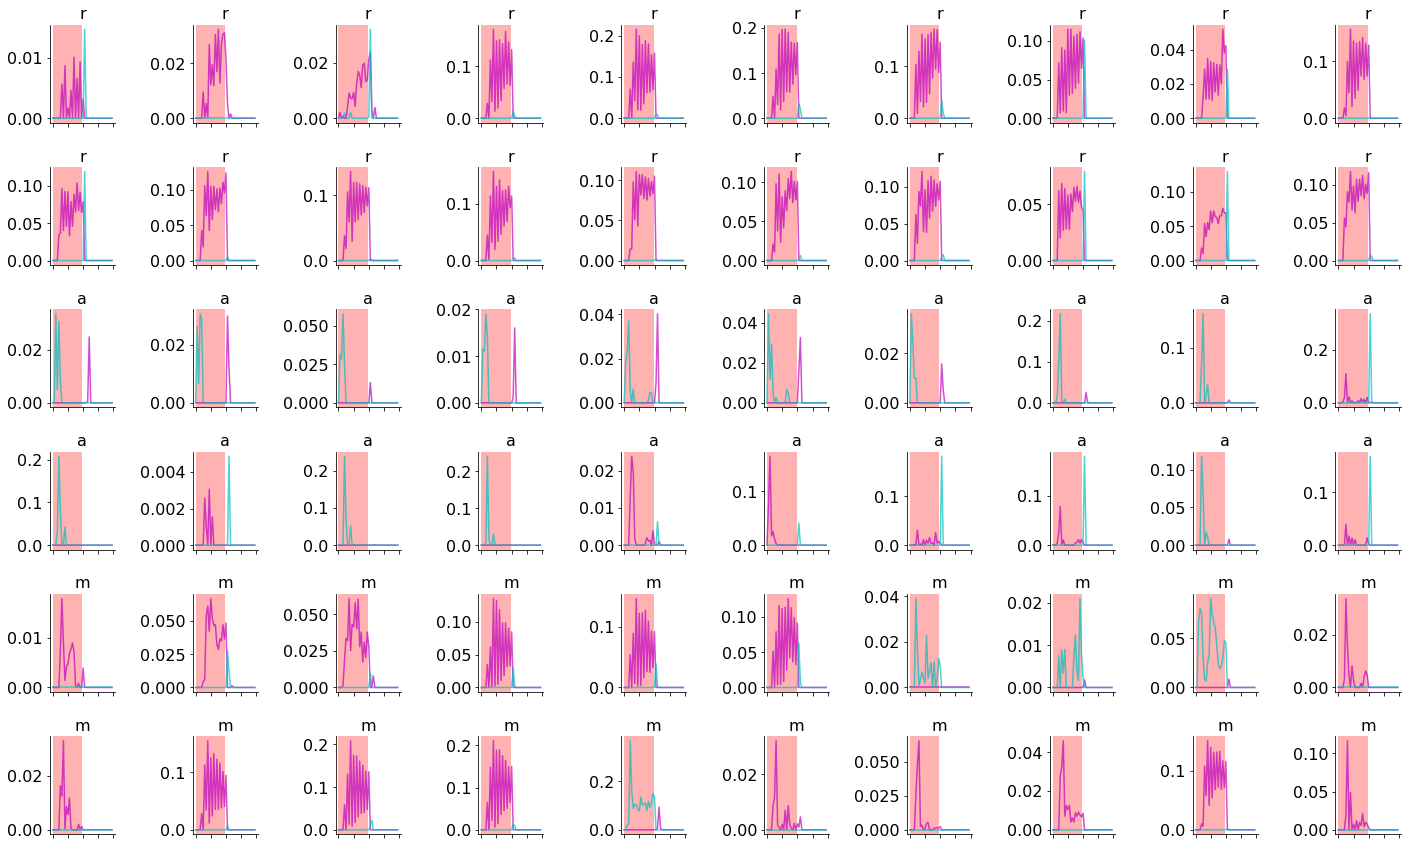

In [17]:
fig = plt.figure(figsize=(20, 20))

# ramp cell
for i in range(20):
    ax = plt.subplot(10, 10, i+1)
    ax.errorbar(range(len(resp_deg0_ind)), resp_deg0_ind[:, ramping_idx[i]], c='m', alpha=0.7)
    ax.errorbar(range(len(resp_deg180_ind)), resp_deg180_ind[:, ramping_idx[i]], c='c', alpha=0.7)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xticks(np.arange(0, 60, 10))
    ax.axvspan(0, stim_frames - 0.5, facecolor='r', alpha=0.3)

    title = ''
    if ramping_idx[i] in ramping_idx:
        title += 'r'
    if ramping_idx[i] in ma_idx:
        title += 'a'
    if ramping_idx[i] in motion_idx:
        title += 'm'
    ax.set_title(title, fontsize=16)

for i in range(20):
    ax = plt.subplot(10, 10, i+21)
    ax.errorbar(range(len(resp_deg0_ind)), resp_deg0_ind[:, ma_idx[i]], c='m', alpha=0.7)
    ax.errorbar(range(len(resp_deg180_ind)), resp_deg180_ind[:, ma_idx[i]], c='c', alpha=0.7)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xticks(np.arange(0, 60, 10))
    ax.axvspan(0, stim_frames - 0.5, facecolor='r', alpha=0.3)

    title = ''
    if ma_idx[i] in ramping_idx:
        title += 'r'
    if ma_idx[i] in ma_idx:
        title += 'a'
    if ma_idx[i] in motion_idx:
        title += 'm'
    ax.set_title(title, fontsize=16)
    
for i in range(20):
    ax = plt.subplot(10, 10, i+41)
    ax.errorbar(range(len(resp_deg0_ind)), resp_deg0_ind[:, motion_idx[i]], c='m', alpha=0.7)
    ax.errorbar(range(len(resp_deg180_ind)), resp_deg180_ind[:, motion_idx[i]], c='c', alpha=0.7)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xticks(np.arange(0, 60, 10))
    ax.axvspan(0, stim_frames - 0.5, facecolor='r', alpha=0.3)

    title = ''
    if motion_idx[i] in ramping_idx:
        title += 'r'
    if motion_idx[i] in ma_idx:
        title += 'a'
    if motion_idx[i] in motion_idx:
        title += 'm'
    ax.set_title(title, fontsize=16)

plt.tight_layout()
plt.show()
plt.close()

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


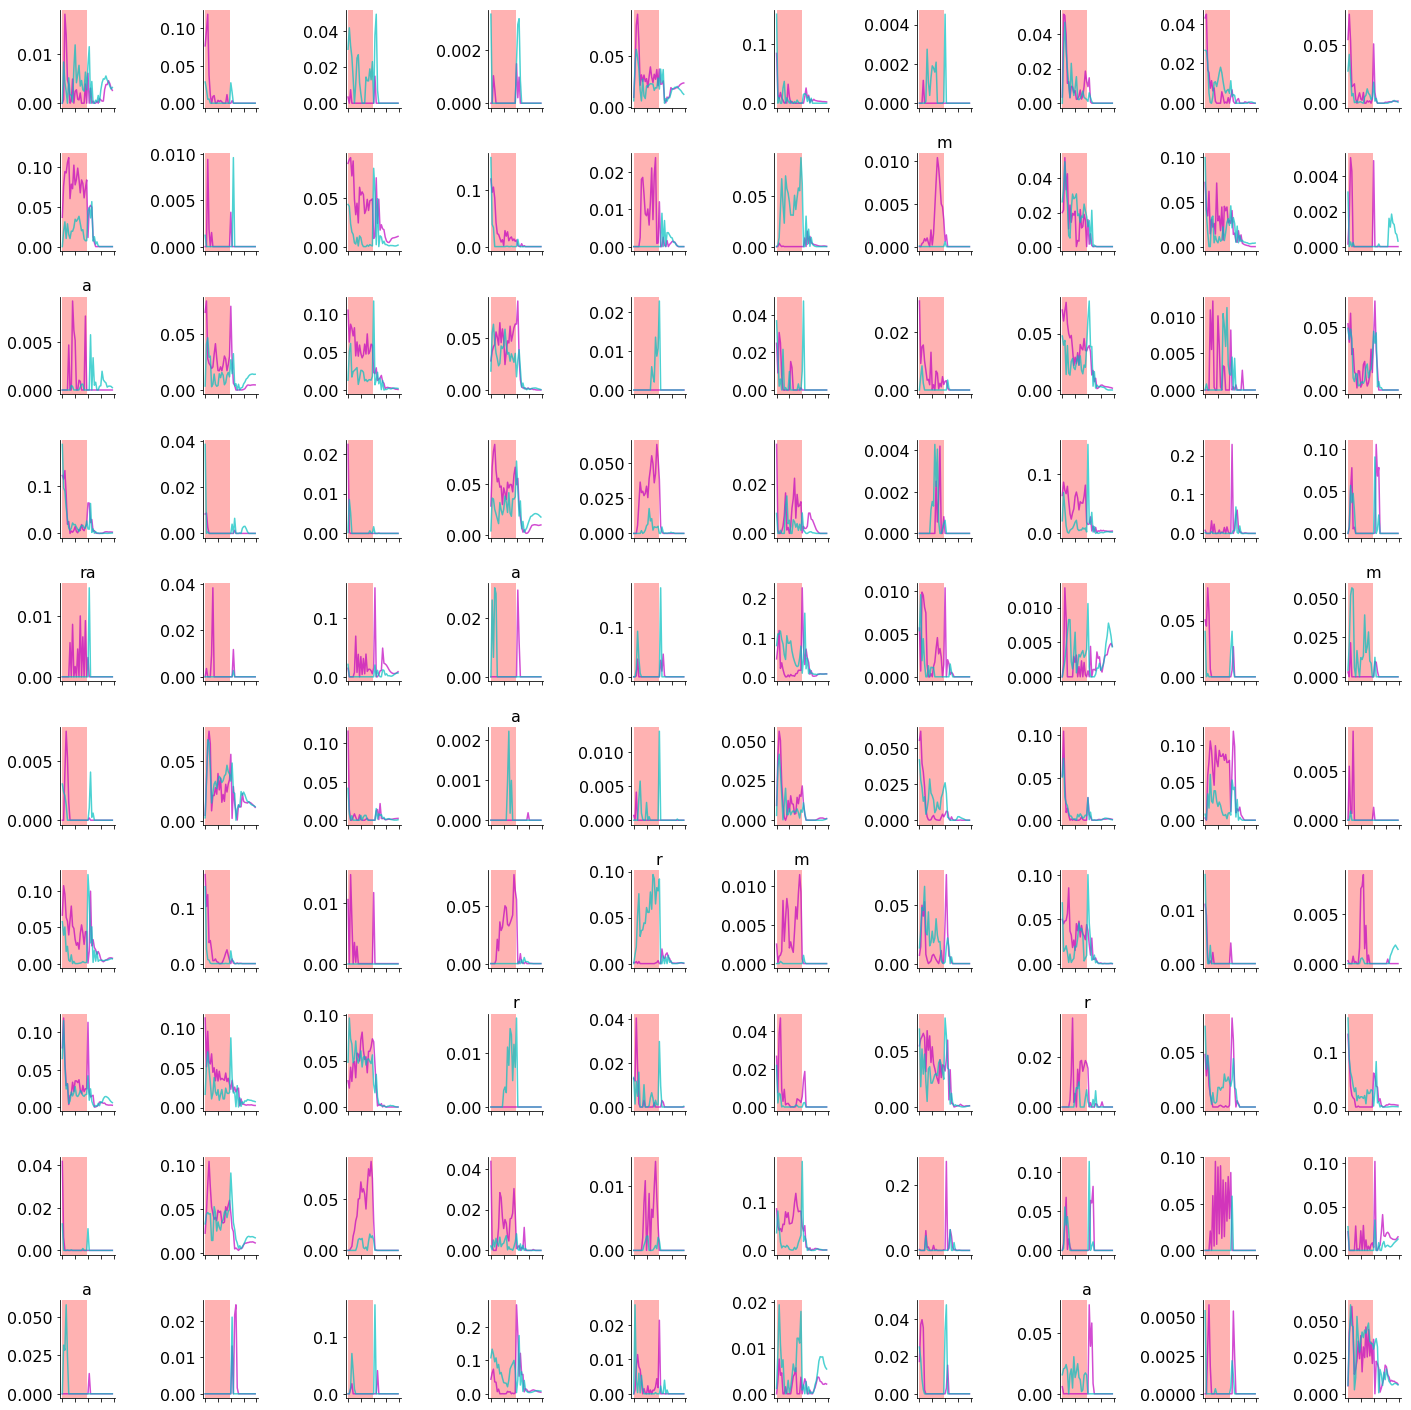

In [69]:
fig = plt.figure(figsize=(20, 20))

i = 100
plotted = 0
while True:
    if i not in flat_idx:
        ax = plt.subplot(10, 10, plotted+1)
        ax.errorbar(range(len(resp_deg0_ind)), resp_deg0_ind[:, i], c='m', alpha=0.7)
        ax.errorbar(range(len(resp_deg180_ind)), resp_deg180_ind[:, i], c='c', alpha=0.7)
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_xticks(np.arange(0, 60, 10))
        ax.axvspan(0, stim_frames - 0.5, facecolor='r', alpha=0.3)
        
        title = ''
        if i in ramping_idx:
            title += 'r'
        if i in ma_idx:
            title += 'a'
        if i in motion_idx:
            title += 'm'
        ax.set_title(title, fontsize=16)
        
        plotted += 1
        if plotted == 100:
            break
    i += 1
    
plt.tight_layout()
plt.show()
plt.close()

# connection

In [81]:
from keras.models import Model, model_from_json
from prednet import PredNet

WEIGHTS_DIR = './model/190724_11/'

weights_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

# Load trained model
f = open(json_file, 'r')
json_string = f.read()
f.close()
train_model = model_from_json(json_string, custom_objects = {'PredNet': PredNet})
train_model.load_weights(weights_file)

In [83]:
w = train_model.get_weights()

for i in range(len(w)):
    print(w[i].shape) # ['a', 'ahat', 'c', 'f', 'i', 'o'] order